In [144]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

%matplotlib inline

In [145]:
# Define some helpers to extract location info

import re
pattern = re.compile('\((-?[\d.]+),\s(-?[\d.]+)\)')

def extract_lat_lng_from_string(addr):
    m = (addr and type(addr) is str) and pattern.search(addr) or None
    return m and [float(m.group(1)), float(m.group(2))] or [None, None]

def extract_lat_lng(df, column):
    extracted = pd.DataFrame(
        [extract_lat_lng_from_string(s) for s in df[column]],
        columns=['lat', 'lng'])
    
    extracted.dropna(inplace=True)
    return extracted

In [146]:
def plot(sample, lat_min, lat_max, lng_min, lng_max):
    plt.figure(figsize=(9,12))
    plt.xlim([lng_min, lng_max])
    plt.ylim([lat_min, lat_max])
    #plt.title("Across all of Detroit")

    loc = all_locations
    plt.scatter(loc['lng'], loc['lat'])

    #bloc = locations['blights']
    #bloc = bloc.sample(int(len(bloc) * sample))
    #plt.scatter(bloc['lng'], bloc['lat'], color='red')

    #cloc = locations['crimes']
    #cloc = cloc.sample(int(len(cloc) * sample))
    #plt.scatter(cloc['lng'], cloc['lat'], color='green')
    
# Plot 1% sample across all of detroit
#plot(0.01, 42.25, 42.46, -83.3, -82.9)

# Plot just a particular area
# plot(1, 42.37, 42.38, -83.07, -83.06)

In [147]:
# Read in all the data
calls = pd.read_csv("blight/data/detroit-311.csv")
blights = pd.read_csv('blight/data/detroit-blight-violations.csv')
crimes = pd.read_csv('blight/data/detroit-crime.csv')
demos = pd.read_csv('blight/data/detroit-demolition-permits.tsv', delimiter='\t')

In [148]:
def loc_slice(df, min_lat, max_lat, min_lng, max_lng):
    df = df[df['lng'] > min_lng]
    df = df[df['lng'] < max_lng]
    df = df[df['lat'] > min_lat]
    df = df[df['lat'] < max_lat]
    return df

In [149]:
# Gather up all lat lon pairs across all the data
locations = {
    'calls': calls[['lat', 'lng']],
    'blights': extract_lat_lng(blights, 'ViolationAddress'),
    'crimes': extract_lat_lng(crimes, 'LOCATION'),
    'demos': extract_lat_lng(demos, 'site_location')
}

# Take out outlier locations (outside of detroit boundaries)
for loc_type in locations:
    locations[loc_type] = loc_slice(locations[loc_type], 42, 43, -84, -82)

calls = calls.ix[locations['calls'].index]
blights = blights.ix[locations['blights'].index]
crimes = crimes.ix[locations['crimes'].index]
demos = demos.ix[locations['demos'].index]
    
all_locations = pd.concat(locations.values(), ignore_index=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e5c8110>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10a59c690>]], dtype=object)

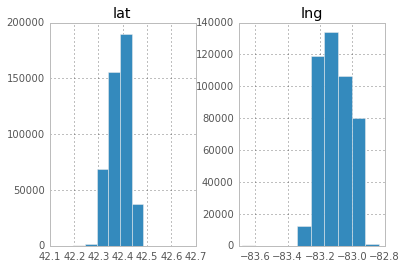

In [150]:
all_locations.hist()

In [151]:
print 'Total incident locations: %d' % len(all_locations)
print '311 calls: %d' % len(calls)
print 'Blight violations: %d' % len(blights)
print 'Crimes: %d' % len(crimes)
print 'Demos: %d' % len(demos)

Total incident locations: 453392
311 calls: 19679
Blight violations: 307804
Crimes: 119594
Demos: 6315


In [152]:
# Use DBSCAN to define "buildings" as just clusters of incidents

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# Compute DBSCAN
X = all_locations.as_matrix()
db = DBSCAN(eps=0.0001, min_samples=1).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 166795


In [153]:
# from http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#example-cluster-plot-dbscan-py

def plot_clusters(db, X):
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    plt.figure(figsize=(9,12))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
                 markeredgecolor='k')#, markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
                 markeredgecolor='k')#, markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

In [154]:
# List of possible features...

# number of 311 calls
# number of 311 calls by issue_type
# number of unique 311 issue types (todo)

# number of blights
# number of blights by ViolationCode
# number of blights by PaymentStatus
# sum of blights JudgmentAmt

# number of crimes
# number of crimes by CATEGORY
# number of crimes by hour (todo)
# number of unique crime CATEGORY

# number of unique incident types (crimes, calls, blights) (todo)
# number of incidents within a 1-month(?) period (todo)
# number of *other* demos in broader area (define broader area) (todo)

In [155]:
# Translate clusters into building ID dataframe, and add lookup function
building_locations = pd.DataFrame({
        'building_id': db.labels_,
        'lat': db.components_[:,0],
        'lng': db.components_[:,1]
    }).drop_duplicates()

def get_building_ids(df):
    joined = pd.merge(df, building_locations, on=['lat', 'lng'], how='left')
    return joined['building_id']

In [156]:
# Figure out actual blights according to demo incidents
blight_feature = locations['demos'].drop_duplicates().copy()
blight_feature['is_blight'] = \
    pd.Series(np.ones(len(blight_feature)), 
                index=blight_feature.index, 
                dtype=bool)

bbs = pd.merge(building_locations, blight_feature, on=['lat','lng'], how='left')
bbs['is_blight'] = bbs['is_blight'].fillna(value=False)
bbs = bbs[['building_id', 'is_blight']].groupby('building_id').agg('max')


# Setup dataset that will be used, include all blights, 
# and sample of non-blights in same amount
import random

blight_index = bbs[bbs['is_blight'] == True].index
non_blight_index = pd.Index(random.sample(bbs[bbs['is_blight'] == False].index, len(blight_index)))
dataset_index = blight_index.append(non_blight_index)

building_blight_status = bbs

In [237]:
# 311 calls

cf = pd.DataFrame()

cf['building_id'] = get_building_ids(pd.DataFrame({
        'lat': calls['lat'],
        'lng': calls['lng']
}))

cf['calls'] = pd.Series(data=np.ones(len(cf)), index=cf.index)

# TODO: parse date / time
#cf['time'] = calls['ticket_created_date_time']

for issue_type in calls['issue_type'].unique():
    col_name = 'calls_' + '_'.join(issue_type.lower().split()[:5])
    cf[col_name] = (calls['issue_type'] == issue_type).astype('int')
    
call_features = cf.groupby('building_id').agg('sum')
#call_features.head(1)

In [236]:
# Blight voilations

bf = pd.DataFrame()

bf['building_id'] = get_building_ids(pd.DataFrame({
        'lat': locations['blights']['lat'],
        'lng': locations['blights']['lng']
}))

bf['blights'] = pd.Series(data=np.ones(len(bf)), index=bf.index)

# TODO: parse date / time
#bf['issued_dt'] = blights['TicketIssuedDT']
#bf['issued_time'] = blights['TicketIssuedTime']

bf['fines'] = blights['JudgmentAmt'].fillna('0').apply(lambda x: float(x.replace('$','')))

for violation_code in blights['ViolationCode'].unique():
    code_label = violation_code.split('-')[0].split('/')[0]
    col_name = 'blights_voilation_code_' + code_label
    
    code_mask = (blights['ViolationCode'] == violation_code).astype(int)
    if col_name not in bf.columns:
        bf[col_name] = code_mask
    else:
        bf[col_name] = bf[col_name] + code_mask

    
for status in blights['PaymentStatus'].unique():
    col_name = 'blights_' + '_'.join(status.lower().split()[:5])
    bf[col_name] = (blights['PaymentStatus'] == status).astype(int)

blight_features = bf.groupby('building_id').agg('sum')
#blight_features.head(1)

In [266]:
# Crimes

crf = pd.DataFrame()

crf['building_id'] = get_building_ids(pd.DataFrame({
        'lat': locations['crimes']['lat'],
        'lng': locations['crimes']['lng']
}))

# TODO: date time parsing
#crf['time'] = crimes['INCIDENTDATE']

# Night crime defined as after 5pm and before 6am
crf['night_crimes'] = ((crimes['HOUR'] > 17) | (crimes['HOUR'] < 6)).astype(int)

crf['crimes'] = pd.Series(data=np.ones(len(bf)), index=bf.index)

for category in crimes['CATEGORY'].unique():
    col_name = 'crimes_' + '_'.join(category.lower().split()[:5])
    crf[col_name] = (crimes['CATEGORY'] == category).astype(int)

crime_features = crf.groupby('building_id').agg('sum')

In [267]:
# Setup features dataframe

base_features = pd.DataFrame({
    'building_id': building_locations['building_id'],
    'incidents': np.ones(len(building_locations))
}).groupby('building_id').agg('sum')

features_agg = pd.concat([
        base_features, 
        crime_features, 
        call_features, 
        blight_features], axis=1).fillna(0)

In [287]:
# And fire up the machine learning

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing

target = bbs.ix[dataset_index,0].values
features = features_agg.ix[dataset_index].values

clf = RandomForestClassifier(n_estimators=40, max_depth=10, max_features=int(np.sqrt(features.shape[1])))
np.mean(cross_val_score(clf, features, target, cv=10))

0.82509278002699049

In [288]:
import operator

importances = {}
clf.fit(features, target)
for i in range(len(features_agg.columns)):
    importances[features_agg.columns[i]] = clf.feature_importances_[i]
    
pd.DataFrame(
    sorted(importances.items(), key=operator.itemgetter(1), reverse=True),
    columns = ['feature', 'importance'])

,feature,importance
0,crimes,0.245595
1,incidents,0.116265
2,night_crimes,0.112757
3,blights_no_payment_applied,0.073354
4,blights,0.067695
5,calls,0.064273
6,fines,0.059028
7,crimes_traffic_violations-motorcycle_violations,0.034294
8,blights_voilation_code_9,0.033121
9,crimes_assault,0.025050
